In order to access the data, we need to make sure that all the required packages
are installed.

In [ ]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playergamelog, teamgamelog, playercareerstats, commonplayerinfo
import matplotlib.pyplot as plt
import numpy as np
import time

First, determine the player who's stats we want to look at. Then get their ID number.

In [ ]:
myPlayer = "LeBron James"
playerInfo = players.find_players_by_full_name(myPlayer)[0]
playerID = playerInfo['id']
print(playerID)

Let's look at all of the seasons that this player has played, and get their stats for each game.

In [ ]:
playerGames = {}
playerInfo = commonplayerinfo.CommonPlayerInfo(playerID, timeout=120).get_dict()
firstSeason = playerInfo['resultSets'][0]['rowSet'][0][24]
lastSeason = playerInfo['resultSets'][0]['rowSet'][0][25]

for first in range(firstSeason, lastSeason + 1):
	time.sleep(3.5)
	second = str(first + 1)[2:]
	year = str(first) + '-' + second
	gameLog = playergamelog.PlayerGameLog(playerID, year, timeout=120).get_dict()
	playerGames[year] = []

	for game in reversed(gameLog['resultSets'][0]['rowSet']):
		playerGames[year].append(game)

Let's then look at the team's games, so that we can see which games the player has missed.

In [ ]:
teamGames = {}
career = playercareerstats.PlayerCareerStats(playerID).get_dict()

for i, first in enumerate(range(firstSeason, lastSeason + 1)):
	second = str(first + 1)[2:]
	year = str(first) + '-' + second
	teamID = career['resultSets'][0]['rowSet'][i][3]
	gameLog = teamgamelog.TeamGameLog(teamID, year).get_dict()
	teamGames[year] = []

	for game in reversed(gameLog['resultSets'][0]['rowSet']):
		teamGames[year].append(game)

for season in teamGames:
	print(season)
	for game in teamGames[season]:
		print(game)

Let's cross reference the team's games with the player's games so that we can see where the player was injured.

In [35]:
fantasyPoints = {}
for season in playerGames:

	offset = 0
	fpoints = []

	for i, game in enumerate(playerGames[season]):

		while game[3] != teamGames[season][i + offset][2]:
			fpoints.append(0)
			offset += 1
		
		fieldGoalsMade = 2 * game[7]
		fieldGoalsAttempted = -1 * game[8]
		freeThrowsMade = 1 * game[13]
		freeThrowsAttempted = -1 * game[14]
		threePointersMade = 1 * game[10]
		rebounds = 1 * game[18]
		assists = 2 * game[19]
		steals = 4 * game[20]
		blocks = 4 * game[21]
		turnovers = -2 * game[22]
		points = 1 * game[24]

		fpoints.append(
			fieldGoalsAttempted + fieldGoalsMade +
			freeThrowsAttempted + freeThrowsMade +
			points + threePointersMade +
			rebounds + assists +
			steals + blocks + turnovers
		)
	
	while len(fpoints) < len(teamGames[season]):
		fpoints.append(0)
		
	fantasyPoints[season] = fpoints

Let's plot our graph.

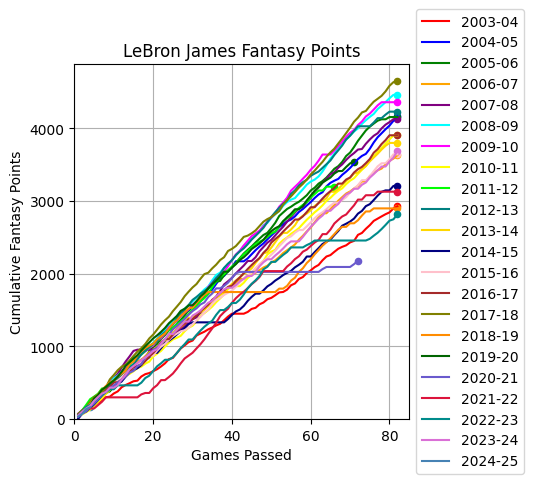

In [41]:
colors = [
    "red", "blue", "green",
    "orange", "purple", "cyan",
    "magenta", "yellow", "lime",
    "teal", "gold", "navy",
    "pink", "brown", "olive",
    "darkorange", "darkgreen", "slateblue",
    "crimson", "darkcyan", "orchid", "steelblue"
]

for i, season in enumerate(fantasyPoints):
	plt.plot(range(1, len(fantasyPoints[season]) + 1), np.cumsum(fantasyPoints[season]), label=season, color=colors[i])
	plt.scatter(len(fantasyPoints[season]), np.cumsum(fantasyPoints[season])[-1], s=20, color=colors[i])
plt.grid(True)
plt.title("LeBron James Fantasy Points")
plt.xlabel("Games Passed")
plt.ylabel("Cumulative Fantasy Points")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.xlim(left=0, right=85)
plt.ylim(bottom=0)
plt.show()